### Load In

In [2]:
''' Make sure you have pandorasim installed and updated '''

import pandorasat as ps
import pandorasim as pp
ps.utils.get_phoenix_model(teff=7000, jmag=10) #this is a temporary fix to an import error with pandorasim
from pandorasim import VisibleSim, NIRSim
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.io import fits
from pandorasat.plotting import animate
from pandorasat.plotting import save_mp4, save_gif
from astropy.time import Time, TimeDelta

### These are commissioning specific functions. 
from CommissFunctions import generate_task_plan

### These are constants that currently don't come from PandoraSat.  
from CommissFunctions import data_rate, bits_per_pix_VIS, compression_fractor_VIS, frame_time_VIS, stored_frames_per_int_VIS, pass_time_min


In [3]:
''' Define a PandoraSat object for calling constants '''
p = ps.PandoraSat()

# This Task May Include Multiple Observations. Set the Observation Number Here:

In [11]:
observation_number = 0  ### 0 indexed, This is used for naming the output files

# Data Volume

Estimate data volume based on obseravtion parameters and estimated rates and sizes.

In [4]:
''' this sets observing parameters for activity '''
VIS_xpix              = p.VISDA.shape[0] ### We collect the full VIS FOV for this task
VIS_ypix              = p.VISDA.shape[1]
regions               = 1
frames_per_int        = 1
num_int               = 200 ### not defined yet -- currently the same as 3.10

''' Calculating data volumes '''
int_and_reset_time    = frame_time_VIS * frames_per_int
bits_per_int          = VIS_xpix * VIS_ypix * regions * bits_per_pix_VIS * stored_frames_per_int_VIS
bits_per_sec          = bits_per_int / int_and_reset_time
test_time             = num_int * int_and_reset_time
bits_per_sec_comp     = bits_per_sec / compression_fractor_VIS
bits_test_total       = bits_per_sec_comp * test_time
Gbits_test_packet     = bits_test_total / 1E9 * 1.1 * 1.25
downlinks             = Gbits_test_packet * 1E9 /(data_rate * 1E6) /pass_time_min /60

print('test time:', test_time, 'seconds')
print(Gbits_test_packet, 'Gbits')
print(downlinks, 'downlinks')

test time: 40.0 seconds
12.303291733333335 Gbits
5.126371555555556 downlinks


# Define Targets

For now, we select an arbitrary primary target to place at the center of the frame. The target selection process is being developed (check with Aisha Iyer or Lindsey Wiser).  

In [5]:
### Posible Targets:
# ...
# ...
# ...
# ...

In [6]:
''' Finds target coordinates based on astropy '''
### You can do this differently as long as you have DEC and RA
target = "GJ 3470"
c = SkyCoord.from_name(target)


''' Identify the start time and end time of the observation '''
start_time = Time.now() 
time_delta = TimeDelta(test_time, format='sec')
end_time = start_time + time_delta


''' Initialize a simulator object '''
sim = VisibleSim(ROI_size=(VIS_xpix, VIS_ypix), nROIs=regions) 


''' Point the simulator at the above target '''
###        RA,   DEC,    Theta 
sim.point(c.ra, c.dec, -40*u.deg)

Output()

Output()

Output()

Output()

In [7]:
''' sim has various attributes you can print out '''
#print(sim.ra, sim.dec, sim.wcs)

''' Notably we have a Catalog of objects visable in the VIS FOV '''
cat = sim.source_catalog
#print(cat)

# Observation

<Axes: title={'center': 'VISDA\n(RA:119.77 deg, Dec:15.39 deg, Roll:-40.00 deg)'}, xlabel='Column [pixel]', ylabel='Row [pixel]'>

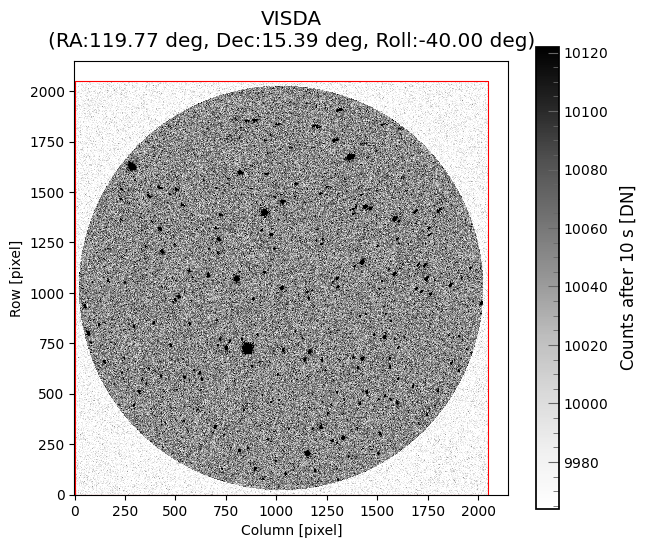

In [8]:
''' Plot the Full Frame Image.'''
sim.show_FFI()

In [9]:
''' Create an Observation. '''

### This returns an astropy.io.fits.HDUList array. 
# `nreads` sets how many reads of the detector are coadded together to create a frame.
# `bin_frames` is a shortcut parameter to speed up computation. Must be a factor of nreads. We can ignore this for low nreads. 
# `nframes` sets how many frames will be returned.
# `start_time` indicates the time of observation. 
# `output_type` is set to array, for now. This make it easy to call in the notebook, but we'll save it as a fits file later. 
###

data = sim.observe(nreads=frames_per_int, bin_frames=1, nframes=num_int, start_time=start_time, output_type="array")

### The shape is: (num ROIs, num frames, nrows, ncolumns)
data.shape

Modeling Pixel Positions: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:21<00:00,  2.69s/it]


(1, 200, 2048, 2048)

In [12]:
'''Animate over the integrations'''
### This is working, but since it is a full frame image object are very small and faint.
#animate(data[0])

### You can save this
#save_mp4(data[0], "output.mp4")
#save_gif(data[0], "output.gif")

'Animate over the integrations'

# Save the simulated observation

In [15]:
''' Re-Create the observation in the correct format for the .fits file (i.e., output_type set to default) '''
### Before, object_type was array for easy use in this notebook, but that is not correct for the .fits file
hdulist = sim.observe(nreads=frames_per_int, nframes=num_int, bin_frames=1, start_time=start_time)


''' Save our simulated observation in a fits file '''
targ = target.replace(" ", "")
ffis_outfile = "3_175_ffis_"+str(targ)+"_obs"+str(observation_number)+".fits" 
hdulist.writeto(ffis_outfile, overwrite=True)

Modeling Pixel Positions: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.17s/it]


In [16]:
''' Show what is in our fits file: 

FITS file extensions: 
    (1) PRIMARY with some information about the simulated observation 
    (2) SCIENCE with information about the data
    (3) ROIs with information about each ROI 
'''
### extension 3 is for ROIs. For this observation, we are taking a full frame, so we will not have ROIs. 

hdul_ffis = fits.open(ffis_outfile)
print(hdul_ffis.info())

#print('.')
#print('.')
#print('.')
#print('-- PRIMARY Headers --')
#print(hdul_ffis[0].header)

#print('.')
#print('.')
#print('.')
#print('-- SCIENCE Headers --')
#print(hdul_ffis[1].header)

#print('.')
#print('.')
#print('.')
#print('-- ROI Headers --')
#print(hdul_ffis[2].header)

Filename: 3_175_ffis_GJ3470_obs0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      23   ()      
  1  SCIENCE       1 ImageHDU        75   (2048, 2048, 200)   int64   
  2  ROITABLE      1 BinTableHDU     22   2R x 1C   [D]   
None


# OUTCOME

### Improvements to the PSF Map

Right now, we aren't including much here, but we can develop this further if it would be useful. 

In [18]:
''' Plot the FFIs from the fits file to compare to expected target locations '''

frame = 0 ### specify which integration to plot - can plot different integrations to see possible jitter
image = hdul_ffis[1].data[frame]

flipped = np.flipud(image) ### flipping the array to match the corrent pixel numbers on the detector
#plt.imshow(flipped, cmap='binary', interpolation='nearest', extent=[0, p.VISDA.shape[0], 0, p.VISDA.shape[1]])

#plt.xlabel('x pixel')
#plt.ylabel('y pixel')
#plt.title('Integration '+str(frame))

# Generate SOC File

In [19]:
'''Here we define the information required for scheduling the observation.'''
### Some of this may change. There are some variables I'm working to understand. 

variables = {
    'visit_id': '3175', ### setting based on task number, for now. Could change.
    'obs_id': f"{observation_number:03}", ### setting based on observation number
    'target': target, 
    'priority': '1', 
    'start_time': str(start_time), 
    'stop_time': str(end_time), 
    'RA': str(c.ra),
    'DEC': str(c.dec), 
    'NIR_AvgGroups': '0', ### no NIR. 
    'NIR_ROI_StartX': '0', 
    'NIR_ROI_StartY': '0', 
    'NIR_ROI_SizeX': '0', 
    'NIR_ROI_SizeY': '0',
    'NIR_SC_Resets1': '0',
    'NIR_SC_Resets2': '0', 
    'NIR_SC_DropFrames1': '0',
    'NIR_SC_DropFrames2': '0',
    'NIR_SC_DropFrames3': '0', 
    'NIR_SC_ReadFrames': '0',
    'NIR_targetID': '', 
    'NIR_SC_Groups': '0',
    'NIR_SC_Integrations': '0', 
    'VIS_StartRoiDetMethod': '0',  ### what is this?
    'VIS_FramesPerCoadd': str(frames_per_int), 
    'VIS_NumTotalFramesRequested': str(num_int), 
    'VIS_TargetRA': str(c.ra), 
    'VIS_TargetDEC': str(c.dec), 
    'VIS_IncludeFieldSolnsInResp': '1', ### what is this?
    'VIS_StarRoiDimension': str(VIS_xpix), 
    'VIS_MaxNumStarRois': '1', ### what is this?
    'VIS_numPredefinedStarRois': '1', ### what is this?
    'VIS_PredefinedStarRoiRa': str(c.ra), 
    'VIS_PredefinedStarRoiDec': str(c.dec), 
    'VIS_targetID': target, ### same as target?
    'VIS_NumExposuresMax': str(num_int), ### what is this?
    'VIS_ExposureTime_us':str( frame_time_VIS * 1000000)  
}

In [20]:
'''Generate the SOC .xml file'''
### This may also change format

output_soc_file = '3_175_'+variables['visit_id']+'_'+variables['obs_id']+'_SOC.xml' 
generate_task_plan(variables, output_soc_file)